In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
from os import listdir
from os.path import exists

In [2]:
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16 as VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Récupération des données

In [6]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'

In [7]:
data = pd.read_csv(path_csv)

## Reformatage du dataset

Transformation de l'arbre en liste et extraction de sa catégorie la plus générale

In [8]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [9]:
data['category'] = data['product_category_list'].apply(lambda l : l[0])

On ne garde que les colonnes utiles pour nous

In [10]:
data_little = data[['image', 'product_category_list', 'category', 'description']].copy()

In [11]:
data_little.columns = ['img', 'cat_lst', 'cat', 'desc']

In [12]:
data_little['img'] = path_img+'/'+data_little['img']

In [13]:
data_little['cat'].value_counts()

cat
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [14]:
list_labels = list(data_little['cat'].value_counts().index)

In [15]:
nb_cat = len(list_labels)

In [16]:
data_little['label'] = data_little['cat'].apply(lambda e : list_labels.index(e))

In [17]:
data_little

,img,cat_lst,cat,desc,label
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Home Furnishing,Key Features of Elegance Polyester Multicolor ...,0
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,1
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,1
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,0
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,0
...,...,...,...,...,...
1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Baby Care,Oren Empower Extra Large Self Adhesive Sticker...,1
1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...,1
1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,1
1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,1


# Embeding et Feature extraction

## VGG16

Chargement du modele

In [18]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Chargement et transformation des images

In [19]:
images_features = []
i=0 
for path in data_little["img"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # prédiction

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## USE

In [20]:
import tensorflow_hub as hub

In [21]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [22]:
sentences = [txt[:len(txt)//2] for txt in data_little['desc']]

In [23]:
textes_features = embed(sentences)

## Combinaison des vecteurs

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
features_final = np.concatenate((textes_features, images_features), axis=1)
features_final.shape

(1050, 4608)

In [26]:
features_final = StandardScaler().fit_transform(features_final)

In [27]:
print(features_final.shape)
pca = decomposition.PCA(n_components=0.99)
features_final_pca = pca.fit_transform(features_final)
print(features_final_pca.shape)

(1050, 4608)
(1050, 869)


# Classification

In [28]:
cls = KMeans(n_clusters=nb_cat, n_init=100)
predict_kmeans = cls.fit_predict(features_final_pca)

In [29]:
predict_kmeans = pd.Series(predict_kmeans)

# Visualisation des résultats

In [30]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=20, early_exaggeration=2, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [31]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [32]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

Représentation initiale

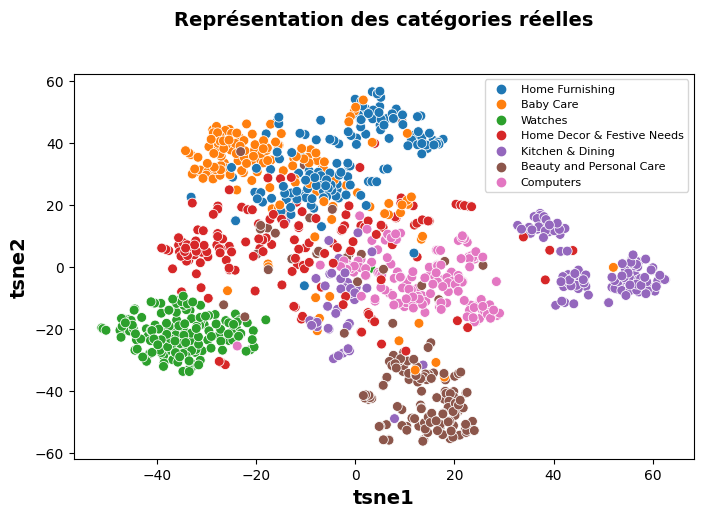

In [33]:
X_tsne = show_representation(features_final_pca, data_little['cat'],
                             title="Représentation des catégories réelles")

Visualisation des prédictions

In [34]:
list_cat, list_col = compare_clustering(data_little['cat'], predict_kmeans, True)
list_trad = [0]*len(list_cat)
for e in range(len(list_cat)):
    i = int(list_col[e][5:])
    list_trad[i] = list_cat[e]

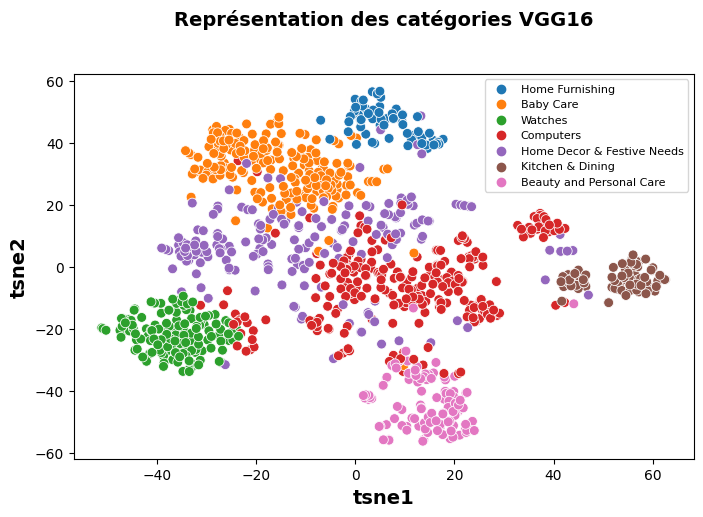

In [35]:
X_tsne = show_representation(features_final_pca,
                             predict_kmeans.apply(lambda e : list_trad[e]),
                             X_tsne=X_tsne,
                             title="Représentation des catégories VGG16")

In [36]:
compare_clustering(data_little['cat'], predict_kmeans)

ARI :  0.5195436279009524


,pred_0,pred_4,pred_2,pred_6,pred_3,pred_5,pred_1
cat,,,,,,,
Computers,143,0,6,0,1,0,0
Watches,14,136,0,0,0,0,0
Home Decor & Festive Needs,9,2,135,2,1,0,1
Baby Care,9,0,19,111,3,1,7
Beauty and Personal Care,26,0,7,8,108,0,1
Kitchen & Dining,62,0,9,1,2,76,0
Home Furnishing,0,0,7,86,0,0,57
